In [1]:
cd /content/drive/MyDrive/VIP_lab/Cancer-Net-PCa/Cancer-Net-PCa

[WinError 3] The system cannot find the path specified: '/content/drive/MyDrive/VIP_lab/Cancer-Net-PCa/Cancer-Net-PCa'
c:\Users\jdewy\vip_lab\Cancer-Net-PCa


In [2]:
!pip install monai

   ---------------------------------------- 1.3/1.3 MB 12.2 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [41]:
import os

for file in os.listdir('data/images'):
    print(file)

ProstateX-0000_ep2d_diff_tra_7.nii
ProstateX-0001_ep2d_diff_tra_8.nii
ProstateX-0002_ep2d_diff_tra_7.nii
ProstateX-0003_ep2d_diff_tra_6.nii
ProstateX-0004_ep2d_diff_tra_7.nii
ProstateX-0005_ep2d_diff_tra_7.nii
ProstateX-0006_ep2d_diff_tra_7.nii
ProstateX-0007_ep2d_diff_tra_8.nii
ProstateX-0008_ep2d_diff_tra_8.nii
ProstateX-0009_ep2d_diff_tra_7.nii
ProstateX-0010_ep2d_diff_tra_8.nii
ProstateX-0011_ep2d_diff_tra_8.nii
ProstateX-0012_ep2d_diff_tra_8.nii
ProstateX-0013_ep2d_diff_tra_7.nii
ProstateX-0014_ep2d_diff_tra_7.nii
ProstateX-0015_ep2d_diff_tra_7.nii
ProstateX-0016_ep2d_diff_tra_7.nii
ProstateX-0017_ep2d_diff_tra_7.nii
ProstateX-0018_ep2d_diff_tra_7.nii
ProstateX-0019_ep2d_diff_tra_7.nii
ProstateX-0020_ep2d_diff_tra_7.nii
ProstateX-0021_ep2d_diff_tra_7.nii
ProstateX-0022_ep2d_diff_tra_7.nii
ProstateX-0023_ep2d_diff_tra_7.nii
ProstateX-0024_ep2d_diff_tra_7.nii
ProstateX-0025_ep2d_diff_tra_7a.nii
ProstateX-0026_ep2d_diff_tra_7.nii
ProstateX-0027_ep2d_diff_tra_7.nii
ProstateX-0028_ep2d

In [111]:
import numpy as np
import nibabel as nib

img = nib.load('data/images/ProstateX-0000_ep2d_diff_tra_7.nii')
img = np.array(img.dataobj)

mask = nib.load('data\masks\ProstateX-0000-Finding1-ep2d_diff_tra_DYNDIST_ADC_ROI.nii')
mask = np.array(mask.dataobj)

In [66]:
img.shape, mask.shape

((84, 128, 19), (84, 128, 19))

In [113]:
np.array(nib.load('data/images/ProstateX-0000_ep2d_diff_tra_7.nii').dataobj).astype(np.uint8)[:, :, 9].max()

255

In [67]:
import numpy as np
import matplotlib.pyplot as plt

def plot_array(img, size=(5,5)):
    plt.figure(figsize=size)
    plt.imshow(img, cmap=plt.cm.bone)
    plt.show()

In [76]:
img[:, :, idx].astype(np.uint8).max()

255

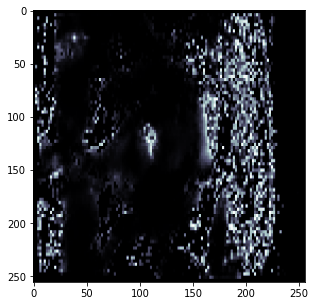

In [139]:
from PIL import Image
import cv2

#mask_std = normalize_image(img[:, :, 9].astype(np.uint8).resize((256, 256), resample=Image.BILINEAR))
#mask_std = cv2.resize(img[:, :, 9].astype(np.uint8), (256, 256), interpolation=cv2.INTER_AREA)
mask_std = resize_image(img[:, :, 9].astype(np.uint8))
plot_array(mask_std)

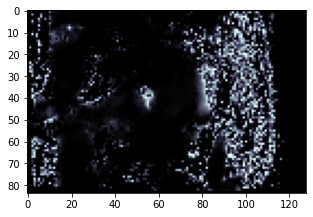

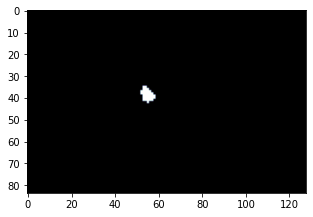

(None, None)

In [124]:
idx = 9

plot_array(img[:, :, idx].astype(np.uint8)), plot_array(mask[:, :, idx].astype(np.uint8))

In [148]:
import glob
import cv2
import matplotlib.pyplot as plt

def list_nii_paths(directory):
    """Generator function to iterate over all nii files in a given directory.

    Args:
        directory: Directory path to search for nii files.

    Yields:
        Sorted array of file paths for each nii file found.
    """
    file_paths = glob.glob(f'{directory}/**/*.nii', recursive=True)
    return np.array(sorted(file_paths))

def normalize_image(img):
    if img.max() == 0:
        return img
    return img / img.max()

def resize_image(img, img_size=(256, 256)):
    return cv2.resize(img, img_size, interpolation=cv2.INTER_AREA)

def visualize_sample(img_tensor, mask_tensor, ):
    img = img_tensor.numpy().squeeze()
    mask = mask_tensor.numpy().squeeze()

    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Image')
    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title('Mask')
    plt.show()

In [149]:
import torch
from torch.utils.data import Dataset
import nibabel as nib

class CancerNetPCa(Dataset):
    def __init__(self, img_path, mask_path, img_size=(256, 256), transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.img_size = img_size
        self.transform = transform

    def __len__(self):
        return len(self.img_path)

    def __getitem__(self, idx):
        img_path = self.img_path[idx]
        mask_path = self.mask_path[idx]

        img = nib.load(img_path).dataobj
        img = np.array(img).astype(np.uint8)

        mask = nib.load(mask_path).dataobj
        mask = np.array(mask).astype(np.uint8)

        slice_num = 9
        img_slice = img[:, :, slice_num]
        mask_slice = mask[:, :, slice_num]

        # standardize 
        img_std = resize_image(normalize_image(img_slice), self.img_size)
        mask_std = resize_image(normalize_image(mask_slice), self.img_size)

        img_tensor = torch.from_numpy(img_std).float()
        mask_tensor = torch.from_numpy(mask_std).long()

        img_tensor = img_tensor.unsqueeze(0)
        mask_tensor = mask_tensor.unsqueeze(0) 

        # apply transformations if provided (add later)
        #if self.transform:

        return img_tensor, mask_tensor

In [150]:
img_path = list_nii_paths('data/images')
mask_path = list_nii_paths('data/masks')

dataset = CancerNetPCa(img_path=img_path, mask_path=mask_path)

In [152]:
img_tensor, mask_tensor = dataset[0]

In [153]:
img_tensor.shape

torch.Size([1, 256, 256])

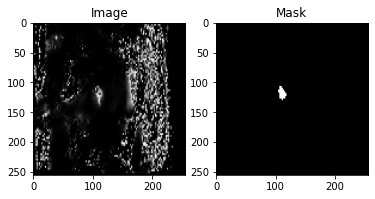

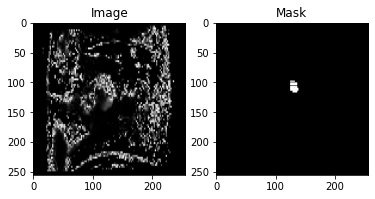

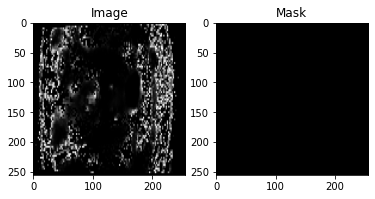

In [154]:
for i in range(3): 
    img_tensor, mask_tensor = dataset[i]
    visualize_sample(img_tensor, mask_tensor)